# Generate data
Running this notebook will:

- create 9 Hidden Markov Models
- show and save plots of some data generated from these models
- generate more X and Z samples and create a dataframe with true labels 
- save used models and generated data to pickle file

In [9]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import pickle
from time import time

FILENAME_SUFFIX = "generated_data"
SAMPLES_PER_MODEL = 100
SAMPLE_LEN = 50
TRAIN_SUBSET_SIZE = 0.6
DIFFERENT_LENGTHS = False # TODO zaimplementowac to jakos sensownie

time_index = int(time())

## Define models

In [10]:
def define_HMM(n_components: int, covariance_type: str, means_: np.ndarray, 
               covars_: np.ndarray, startprob_: np.ndarray, transmat_: np.ndarray) -> hmm.GaussianHMM:
    """Create an instance of hmm.GaussianHMM and set all variables necessary to generate data."""
    # if sum(startprob_) != 1:
    #     print(f"{startprob_ = }")
    #     raise ValueError(f"Sum of startprob_ (= {sum(startprob_)}) must be 1.")
    # for i, row in enumerate(transmat_):
    #     if sum(row) != 1:
    #         print(f"{row = }")
    #         raise ValueError(f"Sum of row {i} of transition matrix (= {sum(row)}) must be 1.")

    model = hmm.GaussianHMM(n_components= n_components, covariance_type= covariance_type) 
    model.means_ = means_
    model.covars_ = covars_
    model.startprob_ = startprob_
    model.transmat_ = transmat_
    return model

In [11]:
model1 = define_HMM(
    n_components = 2, covariance_type = "diag", 
    means_ = np.array([[0.5],[100]]), 
    covars_ = np.array([[0.001],[10]]),
    startprob_ = np.array([0.8, 0.2]), 
    transmat_ = np.array([[0.9, 0.1],
                          [0.5, 0.5]])
)

model2 = define_HMM(
    n_components = 2, covariance_type = "diag",
    means_ = np.array([[0.5],[98]]),
    covars_ = np.array([[0.001],[4]]),
    startprob_ = np.array([0.7, 0.3]),
    transmat_ = np.array([[0.8, 0.2],
                          [0.6, 0.4]])
)

model3 = define_HMM(
    n_components = 2, covariance_type = "diag",
    means_ = np.array([[0.5],[50]]),
    covars_ = np.array([[0.001],[5]]),
    startprob_ = np.array([0.3, 0.7]),
    transmat_ = np.array([[0.6, 0.4],
                          [0.2, 0.8]])
)

model4 = define_HMM(
    n_components= 1, covariance_type= "diag",
    means_ = np.array([[100]]),
    covars_ = np.array([[30]]),
    startprob_ = np.array([1]),
    transmat_ = np.array([[1]]),
)

model5 = define_HMM(
    n_components= 1, covariance_type= "diag",
    means_ = np.array([[50]]),
    covars_ = np.array([[1]]),
    startprob_ = np.array([1]),
    transmat_ = np.array([[1]]),
)

model6 = define_HMM(
    n_components= 1, covariance_type= "diag",
    means_ = np.array([[100]]),
    covars_ = np.array([[1]]),
    startprob_ = np.array([1]),
    transmat_ = np.array([[1]]),
)

model7 = define_HMM(
    n_components= 5, covariance_type= "diag",
    means_ = np.array([[0.1],[20],[30],[200],[300]]),
    covars_ = np.array([[0.001],[0.2],[0.3],[0.5],[0.5]]),
    startprob_ = np.array([0.6, 0.1, 0.1, 0.1, 0.1]),
    transmat_ = np.array([[0.6, 0.0, 0.1, 0.1, 0.2],
                          [0.1, 0.8, 0.05, 0.04, 0.01],
                          [0.1, 0.05, 0.8, 0.04, 0.01],    
                          [0.05, 0.2, 0.02, 0.7, 0.03], 
                          [0.3, 0.03, 0.03, 0.04, 0.6]
                         ])
)

model8 = define_HMM(
    n_components= 3, covariance_type= "diag",
    means_ = np.array([[0.1],[50], [100]]),
    covars_ = np.array([[0.001],[5], [5]]),
    startprob_ = np.array([0.1, 0.7, 0.2]),
    transmat_ = np.array([[0.6, 0.4, 0.0],
                          [0.1, 0.8, 0.1],
                          [0.7, 0.01, 0.29]
                         ])
)

model9 = define_HMM(
    n_components= 3, covariance_type= "diag",
    means_ = np.array([[1],[30], [45]]),
    covars_ = np.array([[0.001],[5], [5]]),
    startprob_ = np.array([0.1, 0.7, 0.2]),
    transmat_ = np.array([[0.5, 0.4, 0.1],
                          [0.1, 0.6, 0.3],
                          [0.2, 0.51, 0.29]
                         ])
)

models_lst = [model1, model2, model3, model4, model5, model6, model7, model8, model9]

## Show plots

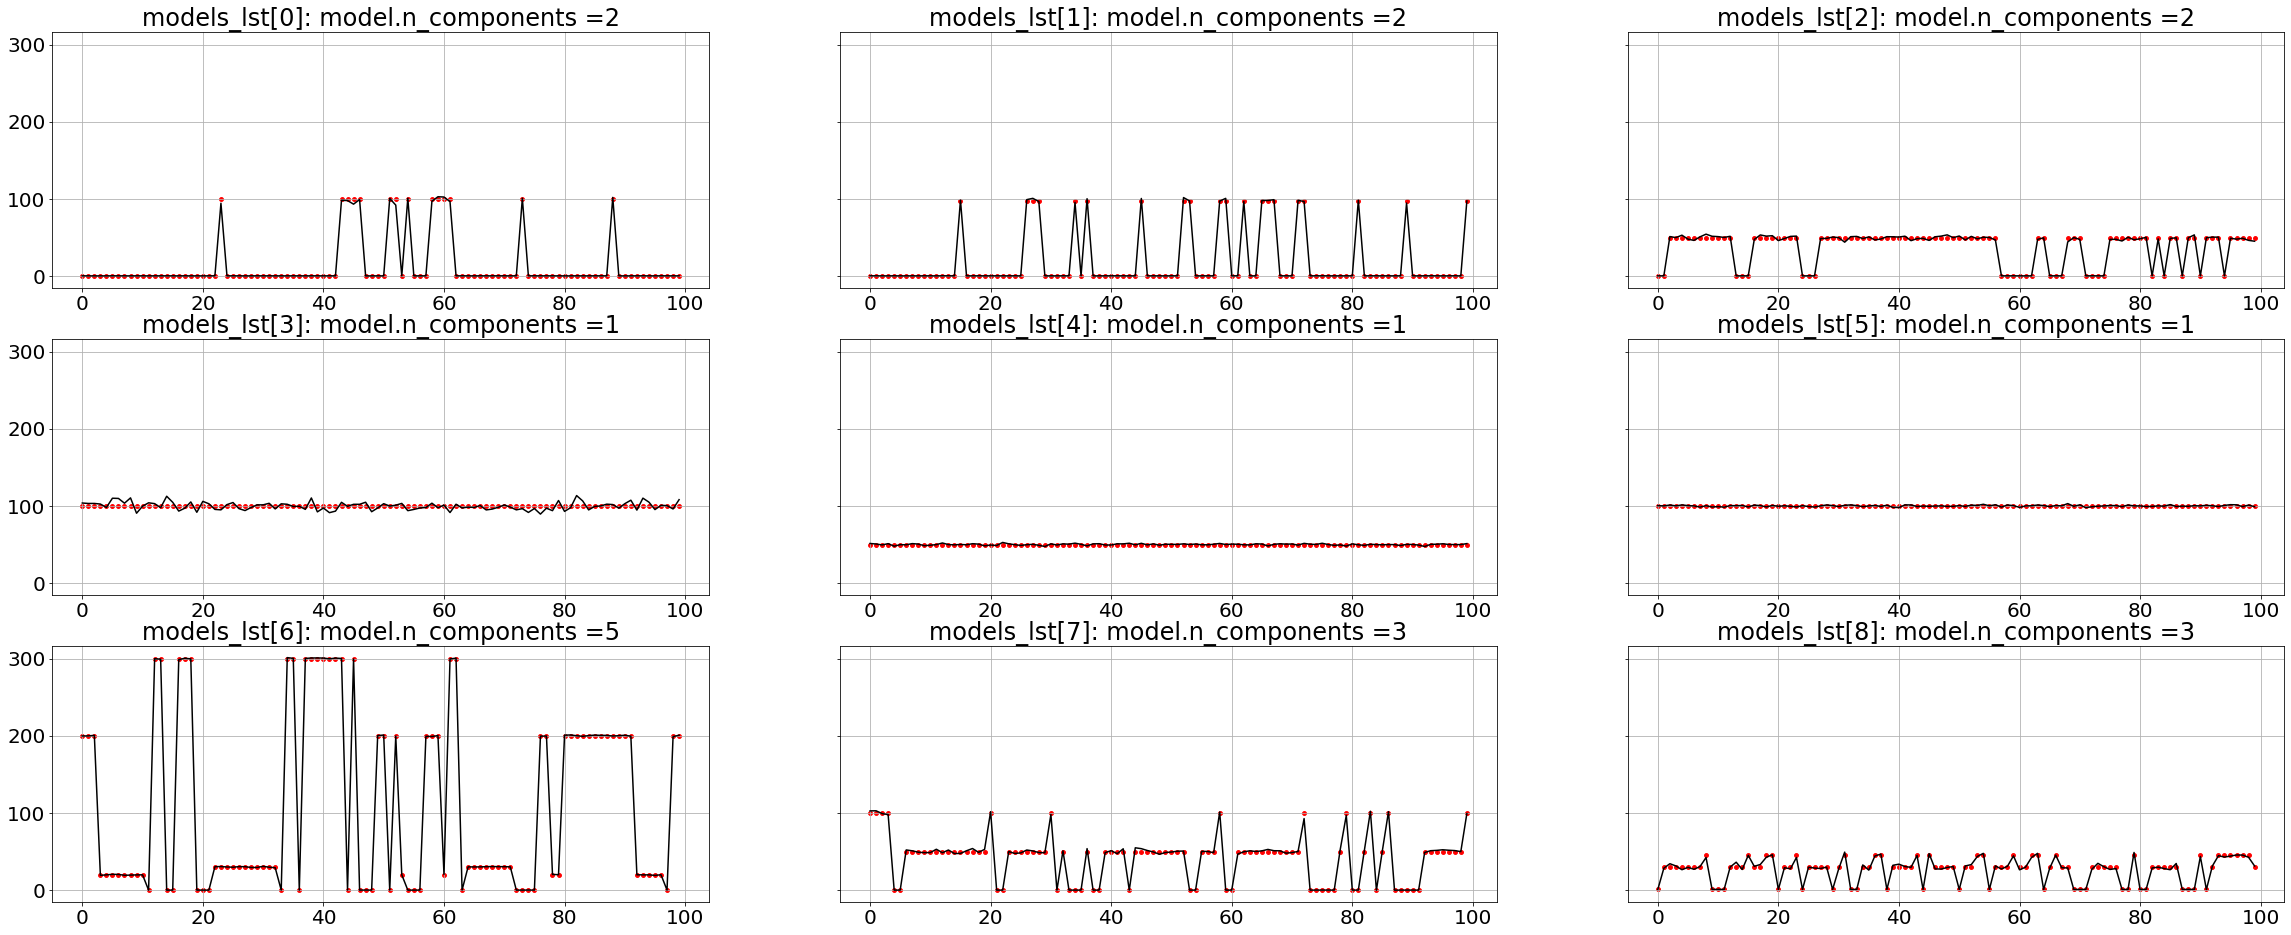

In [12]:
plt.rcParams["figure.figsize"] = (40, 16)
plt.rcParams['font.size'] = 20
fig, axes = plt.subplots(3,3, sharey="all")
for i, ax in enumerate(axes.reshape(-1)):
    model = models_lst[i]
    try:
        X,Z = model.sample(100)
    except Exception as e:
        print(f"Error in model {i}: {e}")
        continue
        
    means = [model.means_[hidden_state] for hidden_state in Z]
    ax.plot(X, color = "black")
    ax.scatter(np.array(range(len(Z))), means, color = "red", s = 15)
    ax.set_title(f"models_lst[{i}]: {model.n_components =}")
    ax.grid()
    
plt.savefig(f"./plots/models_hmm_{time_index}.jpg")
plt.show()

## Generate all data

In [13]:
def generate_data(models_lst: hmm.BaseHMM, samples_per_model: int, sample_len: int) -> tuple:
    """Generate data from list of hmm.BaseHMM instances.
    Returns:
        - labels_df: pd.DataFrame |true_label
        - all_X_samples: a list with generated X samples
        - all_Z_samples: a list with generated hidden states
    """
    all_X_samples = []
    all_Z_samples = []
    true_labels = []
    sample_lengths = []

    for i in range(len(models_lst)):
        model = models_lst[i]
        for j in range(samples_per_model):
            X,Z = model.sample(sample_len)
            all_X_samples.append(X)
            all_Z_samples.append(Z)
            sample_lengths.append(sample_len)
            true_labels.append(i)

    labels_df = pd.DataFrame({"true_label": true_labels})

    return labels_df, all_X_samples, all_Z_samples

In [14]:
labels_df, all_X_samples, all_Z_samples = generate_data(models_lst, SAMPLES_PER_MODEL, SAMPLE_LEN)

## Prepare splits

In [15]:
train_samples_ids = []
test_samples_ids = []
print("Number of samples in train and test splits grouped by true labels:")
print("label |train |test")
for label, sub_df in labels_df.groupby("true_label"):
    n = sub_df.shape[0]
    train_size = int(n*TRAIN_SUBSET_SIZE)
    test_size = n - train_size
    if test_size < 1:
        raise Exception(f"For {TRAIN_SUBSET_SIZE = } and {n = } test subset in group {label} is empty.")
    print(f"{label}     |{train_size}     |{test_size}")
    train_ids = sub_df.sample(8).index.values
    train_samples_ids.extend(train_ids)
    test_samples_ids.extend(sub_df.drop(train_ids).index.values)

indices_split = {
    "train_samples_ids": train_samples_ids, 
    "test_samples_ids": test_samples_ids}

indices_splits_lst = [indices_split]

Number of samples in train and test splits grouped by true labels:
label |train |test
0     |60     |40
1     |60     |40
2     |60     |40
3     |60     |40
4     |60     |40
5     |60     |40
6     |60     |40
7     |60     |40
8     |60     |40


## Save the data

In [16]:
output_filename = f"data/{FILENAME_SUFFIX}_{time_index}.pkl"
data = {
    'data_filename': output_filename,
    'time_index': time_index,
    'models_lst': models_lst,
    'labels_df': labels_df,
    'all_X_samples': all_X_samples,
    'all_Z_samples': all_Z_samples,
    'indices_splits_lst': indices_splits_lst
}

with open(output_filename, 'wb') as f:
    pickle.dump(data, f)
    print(f"Data saved to {output_filename}.")

Data saved to data/generated_data_1657988831.pkl.
